## Install the package dependencies before running this notebook

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob
import matplotlib.pyplot as plt

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset

In [2]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "./"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):

    
    outputs = None
    
    if split=="train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[:int(n * 0.8)]
        
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[:int(n * 0.8)]
        
    elif split == 'val':
        f_in = ROOT_PATH + 'train' + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[int(n * 0.8):]
        
        f_out = ROOT_PATH + 'train' + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[int(n * 0.8):]
    
    else:
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

## Create a DataLoader class for training

In [3]:
torch.cuda.current_device()

0

In [4]:
!nvidia-smi

Fri May 20 17:43:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.81                 Driver Version: 460.67                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:B1:00.0 Off |                  N/A |
|  0%   39C    P8    10W / 250W |   1436MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [5]:
from torch import nn, optim

class Pred(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        
        
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 120)
        )
        
    def forward(self, x):
        x = x.reshape(-1, 100).float()
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.reshape(-1, 60, 2)
        return x

In [6]:
def train(pred, opt, train_dataset, train_loader, val_dataset, val_loader):
    device = torch.device('cuda:0')
    pred = pred.to(device)
    train_losses = []
    val_losses = []
    for epoch in range(50):

        total_loss = 0
        for i_batch, sample_batch in enumerate(train_loader):
            inp, out = sample_batch
            out = out.to(device)
            inp = inp.to(device)
            preds = pred(inp)
            loss = ((preds - out) ** 2).sum()

            opt.zero_grad()
            loss.backward()
            opt.step()

            total_loss += loss.item()

        val_loss = 0
        for i_batch, sample_batch in enumerate(val_loader):
            inp, out = sample_batch
            out = out.to(device)
            inp = inp.to(device)
            preds = pred(inp)
            #print(preds)
            loss = ((preds - out) ** 2).sum()
            val_loss += loss.item()

        train_loss = np.log(total_loss / len(train_dataset))
        val_loss = np.log(val_loss / len(val_dataset))

        print('epoch {} train_loss: {} val_loss: {}'.format(epoch, train_loss, val_loss))
        train_losses.append(train_loss)
        val_losses.append(val_loss)


    plt.title("Loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(train_losses, color ="red", label = "train_loss")
    plt.plot(val_losses, color ="blue", label = "val_loss")
    plt.legend()
    plt.show()

city: austin
epoch 0 train_loss: 17.98660819616703 val_loss: 12.837121983695578
epoch 1 train_loss: 12.252618531389679 val_loss: 12.031263554688273
epoch 2 train_loss: 11.884144990255463 val_loss: 11.867398664677324
epoch 3 train_loss: 11.812445347030234 val_loss: 11.811166039661844
epoch 4 train_loss: 11.789894295737025 val_loss: 11.78075917472188
epoch 5 train_loss: 11.776774672900428 val_loss: 11.747298819816237
epoch 6 train_loss: 11.7657138926964 val_loss: 11.738908254653309
epoch 7 train_loss: 11.75476952891784 val_loss: 11.765813473639968
epoch 8 train_loss: 11.743248634871106 val_loss: 11.81812876703073
epoch 9 train_loss: 11.732959749238908 val_loss: 11.851998545797462
epoch 10 train_loss: 11.720699641857282 val_loss: 11.868764155553711
epoch 11 train_loss: 11.705461929323436 val_loss: 11.881485549404134
epoch 12 train_loss: 11.685504117816558 val_loss: 11.876729446538532
epoch 13 train_loss: 11.6624447623588 val_loss: 11.842729243668408
epoch 14 train_loss: 11.640759553642809

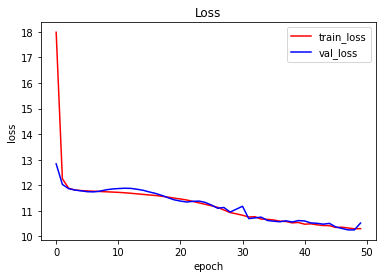

city: miami
epoch 0 train_loss: 19.400749238648743 val_loss: 13.263727164331685
epoch 1 train_loss: 12.482308143405254 val_loss: 11.965792445087972
epoch 2 train_loss: 11.839242542149162 val_loss: 11.7336892565181
epoch 3 train_loss: 11.727533220087366 val_loss: 11.760678941572618
epoch 4 train_loss: 11.67270525022304 val_loss: 11.638977796663086
epoch 5 train_loss: 11.635134512319715 val_loss: 11.642991718417932
epoch 6 train_loss: 11.618686663420391 val_loss: 11.586884755898843
epoch 7 train_loss: 11.605703327854346 val_loss: 11.497270532897975
epoch 8 train_loss: 11.60207906172727 val_loss: 11.55105649696006
epoch 9 train_loss: 11.610973637839695 val_loss: 11.597274611877973
epoch 10 train_loss: 11.61786176172223 val_loss: 11.58304250383974
epoch 11 train_loss: 11.612208294495254 val_loss: 11.520602202162724
epoch 12 train_loss: 11.584342864407846 val_loss: 11.457996111334236
epoch 13 train_loss: 11.577454184942654 val_loss: 11.438816587299536
epoch 14 train_loss: 11.586610815164534

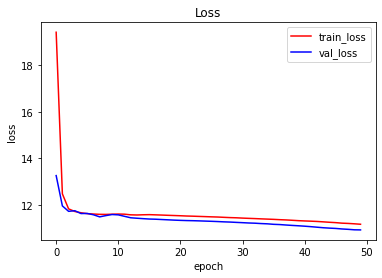

city: pittsburgh
epoch 0 train_loss: 19.208237875716527 val_loss: 15.785945777916098
epoch 1 train_loss: 13.496161848791033 val_loss: 11.742794960668375
epoch 2 train_loss: 11.610152523312074 val_loss: 11.540536699720327
epoch 3 train_loss: 11.514228207777318 val_loss: 11.486032928951765
epoch 4 train_loss: 11.490183267033592 val_loss: 11.480954009885496
epoch 5 train_loss: 11.483070966257195 val_loss: 11.524427576200793
epoch 6 train_loss: 11.48208840652908 val_loss: 11.595128145029479
epoch 7 train_loss: 11.48359381719684 val_loss: 11.56458317313624
epoch 8 train_loss: 11.482548233961642 val_loss: 11.52121580191179
epoch 9 train_loss: 11.479825194660927 val_loss: 11.531455114962704
epoch 10 train_loss: 11.478203392721511 val_loss: 11.515653669990385
epoch 11 train_loss: 11.474399830184458 val_loss: 11.542933206423026
epoch 12 train_loss: 11.473267845483823 val_loss: 11.655665842361312
epoch 13 train_loss: 11.477764233250323 val_loss: 11.679804351133884
epoch 14 train_loss: 11.4820518

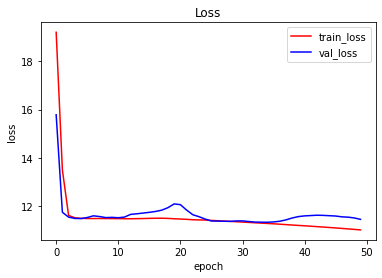

city: dearborn
epoch 0 train_loss: 21.311903739059296 val_loss: 17.118561605197872
epoch 1 train_loss: 15.653776686519747 val_loss: 13.835013852554246
epoch 2 train_loss: 13.146736492954211 val_loss: 12.413192919350447
epoch 3 train_loss: 12.335390733135975 val_loss: 12.392214177569931
epoch 4 train_loss: 12.261408197670065 val_loss: 12.449477980950316
epoch 5 train_loss: 12.231726577242824 val_loss: 12.393865729943931
epoch 6 train_loss: 12.210015113580896 val_loss: 12.293725441023721
epoch 7 train_loss: 12.196073028633021 val_loss: 12.210579329583922
epoch 8 train_loss: 12.193146065769817 val_loss: 12.176156314919517
epoch 9 train_loss: 12.195370658276508 val_loss: 12.180277977658003
epoch 10 train_loss: 12.19650492150249 val_loss: 12.193361509557706
epoch 11 train_loss: 12.19715879480014 val_loss: 12.201439811620727
epoch 12 train_loss: 12.196019341596882 val_loss: 12.19971700380083
epoch 13 train_loss: 12.19413298677179 val_loss: 12.193371220099433
epoch 14 train_loss: 12.191969786

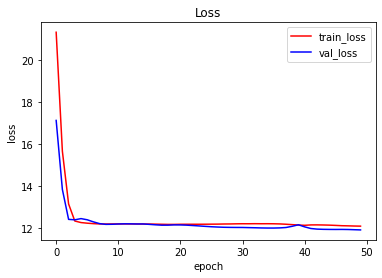

city: washington-dc
epoch 0 train_loss: 19.96987610581528 val_loss: 17.20728226809459
epoch 1 train_loss: 17.139901005726994 val_loss: 16.833078484754708
epoch 2 train_loss: 15.344259912892912 val_loss: 12.9716022030029
epoch 3 train_loss: 12.440677561268147 val_loss: 12.053878627832214
epoch 4 train_loss: 11.94727534294482 val_loss: 11.813157932203962
epoch 5 train_loss: 11.820609185737567 val_loss: 11.724986949419234
epoch 6 train_loss: 11.772752506012015 val_loss: 11.685124440032531
epoch 7 train_loss: 11.74759238971206 val_loss: 11.66179239996669
epoch 8 train_loss: 11.732245835554519 val_loss: 11.644485391944167
epoch 9 train_loss: 11.722099181860683 val_loss: 11.630844200863905
epoch 10 train_loss: 11.71458528652475 val_loss: 11.622185678164751
epoch 11 train_loss: 11.708905949793925 val_loss: 11.619313728556255
epoch 12 train_loss: 11.70399128095519 val_loss: 11.624570743566721
epoch 13 train_loss: 11.698639720451254 val_loss: 11.637580519236705
epoch 14 train_loss: 11.692410789

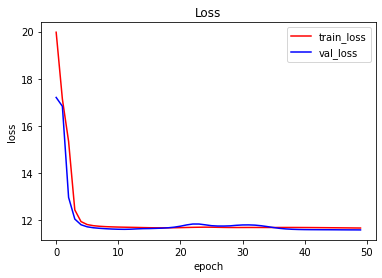

city: palo-alto
epoch 0 train_loss: 19.179321586994828 val_loss: 18.10421628838962
epoch 1 train_loss: 17.33022498734484 val_loss: 16.248275275681017
epoch 2 train_loss: 15.200183011117891 val_loss: 12.826233732207813
epoch 3 train_loss: 12.537442020554177 val_loss: 12.350717283011155
epoch 4 train_loss: 12.316021464882292 val_loss: 12.24409624718668
epoch 5 train_loss: 12.240139310771445 val_loss: 12.197446456993937
epoch 6 train_loss: 12.197668781740743 val_loss: 12.183867436046363
epoch 7 train_loss: 12.17160438325908 val_loss: 12.172721914502402
epoch 8 train_loss: 12.1512398466336 val_loss: 12.146326800373979
epoch 9 train_loss: 12.136230941629858 val_loss: 12.117455024428399
epoch 10 train_loss: 12.124389506164361 val_loss: 12.095160651363859
epoch 11 train_loss: 12.114905748666034 val_loss: 12.081843588848633
epoch 12 train_loss: 12.105121966377016 val_loss: 12.074052782460614
epoch 13 train_loss: 12.09547753318971 val_loss: 12.069179488991818
epoch 14 train_loss: 12.08700765888

In [ ]:
%%time
import pickle
#train city models
for city in cities:
    print('city: ' + city)
    batch_sz = 128  # batch size
    train_dataset  = ArgoverseDataset(city = city, split = 'train')
    train_loader = DataLoader(train_dataset,batch_size=batch_sz)
    val_dataset = ArgoverseDataset(city = city, split = 'val')
    val_loader = DataLoader(val_dataset,batch_size=batch_sz)
    
    pred = Pred()
    opt = optim.Adam(pred.parameters(), lr=1e-4)
    train(pred, opt, train_dataset, train_loader, val_dataset, val_loader)
    pickle.dump(pred, open('models/ta_model_baseline_' + city + '_large', 'wb'))

In [ ]:
import pandas as pd
cols = np.array(['v' + str(i) for i in range(120)])
all_preds = []
for city in cities:
    load_pred = pickle.load(open('models/ta_model_baseline_' + city + '_large', 'rb'))
    test_dataset = get_city_trajectories(city = city, split = 'test')
    device = torch.device('cuda:0')
    load_pred = load_pred.to(device)
    preds = load_pred(torch.from_numpy(test_dataset[0]).to(device))
    preds_reshaped = preds.reshape(preds.size()[0], 120)
    preds_numpy = preds_reshaped.cpu().detach().numpy()
    ids = np.array([str(i) + '_' + city for i in range(len(preds_numpy))])
    predictions = pd.DataFrame(preds_numpy, columns=cols)
    predictions.insert(0, 'ID', ids)
    all_preds.append(predictions)
    
all_predictions = pd.concat(all_preds, ignore_index = True)

In [ ]:
all_predictions

In [ ]:
all_predictions.to_csv('out.csv', index=False)

In [ ]:
pd.read_csv('out.csv')